<a href="https://colab.research.google.com/github/kyhofer/type-1-simulation/blob/master/Type_1_model_EKF_discrete_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

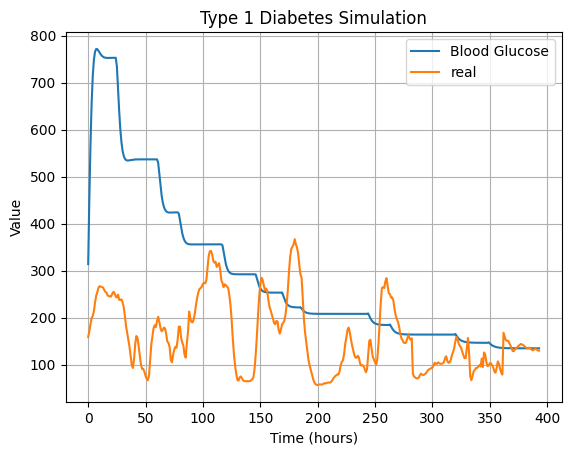

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

class DiscreteKalmanFilter:
    def __init__(self, A, B, H, Q, R, initial_state_mean, initial_state_covariance):
        self.A = A
        self.B = B
        self.H = H
        self.Q = Q
        self.R = R
        self.state_mean = initial_state_mean
        self.state_covariance = initial_state_covariance

    def predict(self, control_input):
        # Predict the next state
        self.state_mean = np.dot(self.A, self.state_mean) + np.dot(self.B, control_input)
        self.state_covariance = np.dot(np.dot(self.A, self.state_covariance), self.A.T) + self.Q

    def update(self, measurement):
        # Measurement update
        innovation = measurement - np.dot(self.H, self.state_mean)
        innovation_covariance = np.dot(np.dot(self.H, self.state_covariance), self.H.T) + self.R
        kalman_gain = np.dot(np.dot(self.state_covariance, self.H.T), np.linalg.inv(innovation_covariance))

        # Update state estimate
        self.state_mean += np.dot(kalman_gain, innovation)
        self.state_covariance = np.dot(np.eye(len(self.state_mean)) - np.dot(kalman_gain, self.H), self.state_covariance)


# Define the simplified diabetes model - similar to 5C_EKF_nonlinear_planar_drone_with_unknown_mass.ipynb
def diabetes_model():     #state, t, G_in, I_in, alpha, beta, C, D, E
    dt = 0.1
    G_in = k1 * u1
    I_in = k2 * u2
    #G, I = state
    #continuous time equations
    #dGdt = G_in - alpha * G - beta * G * I
    #dIdt = I_in + C * G - (D * I) / (E + I)
    #discrete time equations - similar to 5C_EKF_nonlinear_planar_drone_with_unknown_mass.ipynb
    G_n+ = G_n + (delta_t)*(G_in - alpha*G_n - beta*G_n*I_n)
    I_n+ = I_n + (delta_t)*(I_in + C*G_n - (D*I_n)/(E+I_n))
    return [G_n+, I_n+]


# Read real data from Excel
excel_file = "BG_data.xlsx"
data_df = pd.read_excel(excel_file)
real_bg_data = data_df["BloodGlucose"].tolist()

insulin_data = data_df["Insulin"].values
carbohydrate_data = data_df["Carbohydrates"].values
# Time vector
# Adjust the length of t
t = np.linspace(0, 393,394) # len(G_out))


# Simulation parameters / values from paper
E = 2300 #Half saturation value 2300
D = 15200 # max insulin clearance rate 1500
C = .2298  # insluiln secretion rate .2298
alpha = .00002 # Independent insulin rate .00002
beta = .00075919  # dependent insulin rate .00075919

# Time vector (24 hours)
t = np.linspace(0, 393,394)

# Initial conditions
G_initial = 159  # Initial blood glucose level
I_initial = 0    # Initial insulin concentration
G_out[0] = G_initial
# Initialize Kalman filter
A = np.eye(2)  # State transition matrix
B = np.eye(2)  # Control matrix (direct control over both G and I)
H = np.eye(2)  # Observation matrix (identity)
Q = np.eye(2) * 1e-8  # Process noise covariance
R = np.eye(2) * 1e6     # Measurement noise covariance
initial_state_mean = np.array([G_initial, I_initial])  # Initial state mean
initial_state_covariance = np.eye(2) * 1              # Initial state covariance
kalman_filter = DiscreteKalmanFilter(A, B, H, Q, R, initial_state_mean, initial_state_covariance)

# Integrate the ODE using odeint
state = np.array([G_initial, I_initial])  # Initial state
G_out = np.zeros_like(t)
I_out = np.zeros_like(t)
for i in range(len(t)):
    # Get insulin and carbohydrate values from the Excel data
    I_in = insulin_data[i]
    G_in = carbohydrate_data[i]


    # Predict the next state using the Kalman filter with control inputs
    kalman_filter.predict([I_in, G_in])

    # Update the state estimate using the blood glucose measurement
    kalman_filter.update(state)

    # Integrate the ODEs over the next time step
    state = odeint(diabetes_model, state, [0, 1], args=(kalman_filter.state_mean[0], kalman_filter.state_mean[1], alpha, beta, C, D, E))[-1]

    # Save the results
    G_out[i] = state[0]
    I_out[i] = state[1]

# Plot the results
plt.plot(t, G_out, label='Blood Glucose')
plt.plot(t, real_bg_data, label='real')
plt.xlabel('Time (hours)')
plt.ylabel('Value')
plt.title('Type 1 Diabetes Simulation')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
print(G_out[0])

314.0386925919834


convert to discrete time
extended kalman filter -